LSTM Mortes de Covid

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [23]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i+look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_history(history):
    mse = history.history['loss']
    val_mse = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation LOSS - MSE')
    plt.xlabel('epoca')
    plt.ylabel('mse')
    plt.legend()
    
def predict_until_new_year(dataset, look_back=1):
    predictArr = []
    predictArr = np.array([], dtype=np.float64)
    predictArr = predictArr.astype('float32').reshape(-1,1)
    X = np.array(dataset.newCases)
    X = X.astype('float32').reshape(-1,1)
    ano_novo = datetime.strptime('2021-12-31', '%Y-%m-%d')
    hoje = datetime.today()
    dias_ate_ano_novo = abs((ano_novo - hoje).days)
    print(f"dias até o ano novo {dias_ate_ano_novo}")
    for i in range(dias_ate_ano_novo, 0, -1):
        print(f"prevendo taxa de casos para o dia {i} até o ano novo")
        data_para_previsao = scaler.fit_transform(X[look_back*-1:])
        data_para_previsao = np.reshape(data_para_previsao, (1, data_para_previsao.shape[0], 1))
        predict = model.predict(data_para_previsao)
        invpredict = scaler.inverse_transform(predict)
        X = np.append(X, invpredict, axis=0)
        predictArr = np.append(predictArr, invpredict, axis=0)
    return predictArr

def predict_for_next_year(dataset, look_back=1):
    predictArr = []
    predictArr = np.array([], dtype=np.float64)
    predictArr = predictArr.astype('float32').reshape(-1,1)
    X = np.array(dataset.newCases)
    X = X.astype('float32').reshape(-1,1)
    print(f"Prevendo casos para o próximo ano!!")
    for i in range(1, 365, 1):
        print(f"prevendo taxa de casos para o dia {i} do próximo ano")
        data_para_previsao = scaler.fit_transform(X[look_back*-1:])
        data_para_previsao = np.reshape(data_para_previsao, (1, data_para_previsao.shape[0], 1))
        predict = model.predict(data_para_previsao)
        invpredict = scaler.inverse_transform(predict)
        X = np.append(X, invpredict, axis=0)
        predictArr = np.append(predictArr, invpredict, axis=0)
    return predictArr

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv")

In [4]:
# change date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# print all available columns
print(df.columns)

# filter data for Brazil, and show only the specified columns
data_BR = df.query("state == 'TOTAL'")[['date', 'newCases']]

# display the dataframe
data_BR

Index(['epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths',
       'newCases', 'totalCases', 'deathsMS', 'totalCasesMS',
       'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants',
       'deaths_by_totalCases', 'recovered', 'suspects', 'tests',
       'tests_per_100k_inhabitants', 'vaccinated',
       'vaccinated_per_100_inhabitants', 'vaccinated_second',
       'vaccinated_second_per_100_inhabitants', 'vaccinated_single',
       'vaccinated_single_per_100_inhabitants', 'vaccinated_third',
       'vaccinated_third_per_100_inhabitants'],
      dtype='object')


,date,newCases
1,2020-02-25,1
3,2020-02-26,0
5,2020-02-27,0
7,2020-02-28,1
9,2020-02-29,0
...,...,...
16281,2021-10-14,15232
16309,2021-10-15,14294
16337,2021-10-16,9765
16365,2021-10-17,6181


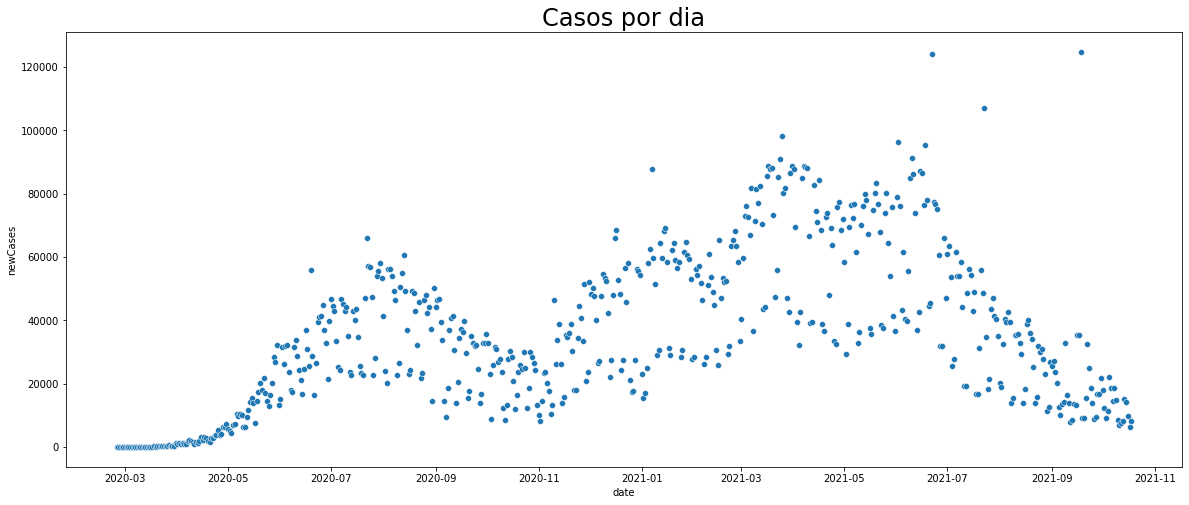

In [5]:
fig = plt.figure(figsize=(20,8))
sns.scatterplot(x=data_BR.date, y=data_BR.newCases)
plt.title('Casos por dia', size=24)
plt.show()

<AxesSubplot:xlabel='newCases', ylabel='Count'>

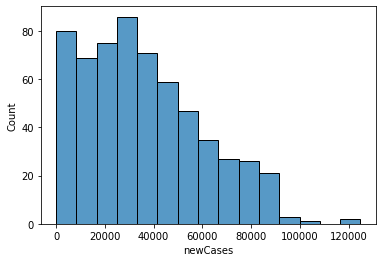

In [6]:
sns.histplot(data_BR.newCases)

# Previsão

In [7]:
X = np.array(data_BR.newCases)
X = X.astype('float32').reshape(-1,1)
X.shape

(602, 1)

In [8]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [9]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:len(X),:]
test =  X[train_size:len(X),:]

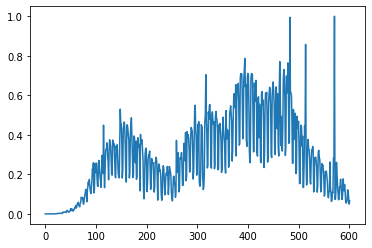

In [10]:
plt.plot(train)

In [11]:
best = 0
best_mse = np.Infinity
for n in range(1, 21, 1):
    look_back = n
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, 1),return_sequences=True, dropout=0.2))
    model.add(LSTM(64, input_shape=(128, 1), dropout=0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)
    mse = min(history.history['val_loss'])
    if best_mse > mse:
        best_mse = mse
        best = n
    print(f"look back {n} - {mse} | best {best} - {best_mse}")    

look back 1 - 0.02305046222332841 | best 1 - 0.02305046222332841
look back 2 - 0.021918803722265946 | best 2 - 0.021918803722265946
look back 3 - 0.016535247572474 | best 3 - 0.016535247572474
look back 4 - 0.013981538895074667 | best 4 - 0.013981538895074667
look back 5 - 0.00975656583436879 | best 5 - 0.00975656583436879
look back 6 - 0.011673860134568264 | best 5 - 0.00975656583436879
look back 7 - 0.010889313667142384 | best 5 - 0.00975656583436879
look back 8 - 0.01139650976859568 | best 5 - 0.00975656583436879
look back 9 - 0.010399404674214937 | best 5 - 0.00975656583436879
look back 10 - 0.010070567206656921 | best 5 - 0.00975656583436879
look back 11 - 0.011262930454093073 | best 5 - 0.00975656583436879
look back 12 - 0.009805592792522941 | best 5 - 0.00975656583436879
look back 13 - 0.008920458067174364 | best 13 - 0.008920458067174364
look back 14 - 0.009580350502330238 | best 13 - 0.008920458067174364
look back 15 - 0.009333484400092334 | best 13 - 0.008920458067174364
look

In [11]:
# quantidade de atrasos
look_back = 19

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [12]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1),return_sequences=True, dropout=0.2))
model.add(LSTM(64, input_shape=(128, 1), dropout=0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 19, 128)           66560     
_________________________________________________________________
lstm_42 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 33        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [15]:
checkpointer = ModelCheckpoint(filepath='./modelo_lstm_covid_casos.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, callbacks=[checkpointer])

Train on 581 samples, validate on 161 samples
Epoch 1/100
581/581 [==============================] - 20s 35ms/step - loss: 0.0339 - val_loss: 0.0299

Epoch 00001: val_loss improved from inf to 0.02990, saving model to ./modelo_lstm_covid_casos.hdf5
Epoch 2/100
581/581 [==============================] - 20s 34ms/step - loss: 0.0302 - val_loss: 0.0336

Epoch 00002: val_loss did not improve from 0.02990
Epoch 3/100
581/581 [==============================] - 20s 34ms/step - loss: 0.0317 - val_loss: 0.0335

Epoch 00003: val_loss did not improve from 0.02990
Epoch 4/100
581/581 [==============================] - 20s 34ms/step - loss: 0.0298 - val_loss: 0.0366

Epoch 00004: val_loss did not improve from 0.02990
Epoch 5/100
581/581 [==============================] - 20s 34ms/step - loss: 0.0275 - val_loss: 0.0314

Epoch 00005: val_loss did not improve from 0.02990
Epoch 6/100
581/581 [==============================] - 20s 35ms/step - loss: 0.0253 - val_loss: 0.0242

Epoch 00006: val_loss impro

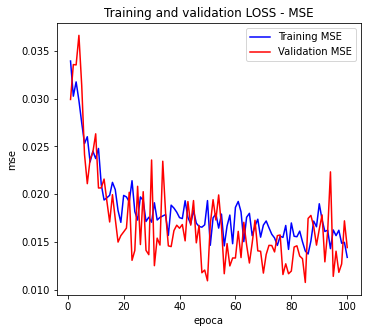

In [16]:
plot_history(history)

In [13]:
model = load_model("./modelo_lstm_covid_casos.hdf5")
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [14]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [15]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12410.84 RMSE
Test Score: 12962.25 RMSE


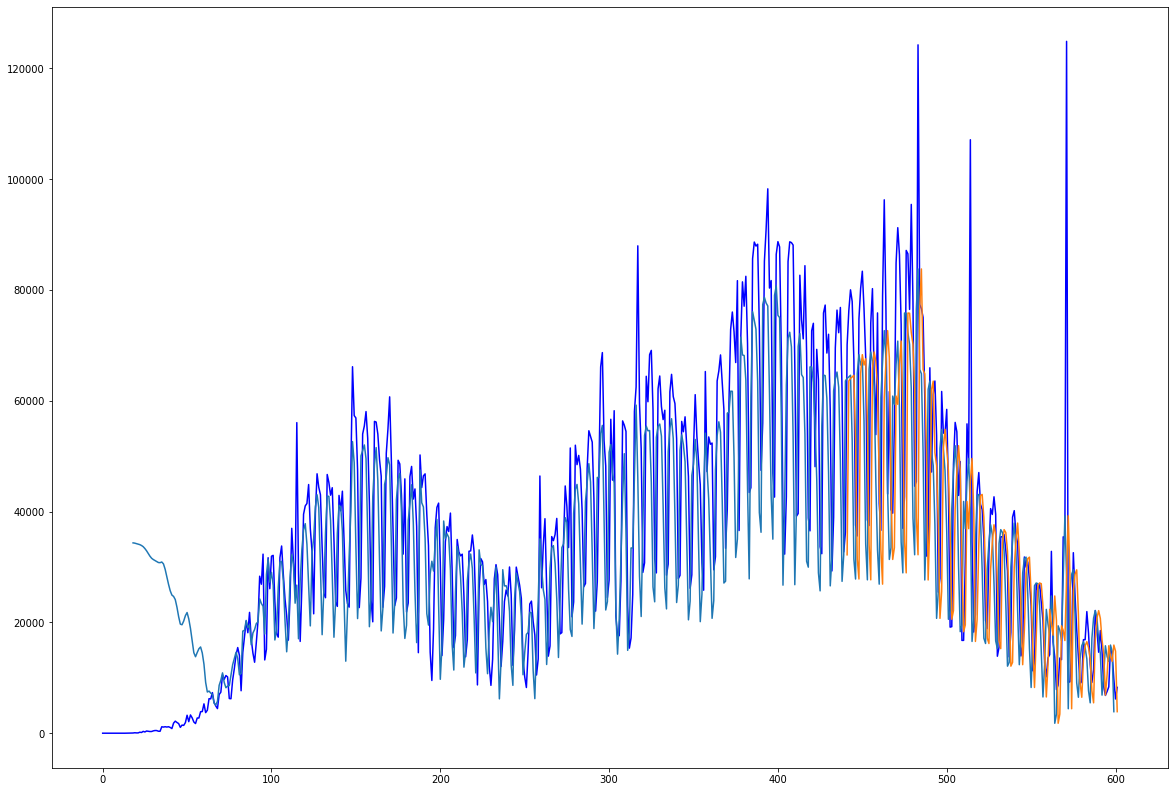

In [16]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(X)-len(testPredict):len(X), :] = testPredict

# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [17]:
previsoes_final_ano = predict_until_new_year(data_BR, look_back)

dias até o ano novo 73
prevendo taxa de casos para o dia 73 até o ano novo
prevendo taxa de casos para o dia 72 até o ano novo
prevendo taxa de casos para o dia 71 até o ano novo
prevendo taxa de casos para o dia 70 até o ano novo
prevendo taxa de casos para o dia 69 até o ano novo
prevendo taxa de casos para o dia 68 até o ano novo
prevendo taxa de casos para o dia 67 até o ano novo
prevendo taxa de casos para o dia 66 até o ano novo
prevendo taxa de casos para o dia 65 até o ano novo
prevendo taxa de casos para o dia 64 até o ano novo
prevendo taxa de casos para o dia 63 até o ano novo
prevendo taxa de casos para o dia 62 até o ano novo
prevendo taxa de casos para o dia 61 até o ano novo
prevendo taxa de casos para o dia 60 até o ano novo
prevendo taxa de casos para o dia 59 até o ano novo
prevendo taxa de casos para o dia 58 até o ano novo
prevendo taxa de casos para o dia 57 até o ano novo
prevendo taxa de casos para o dia 56 até o ano novo
prevendo taxa de casos para o dia 55 até 

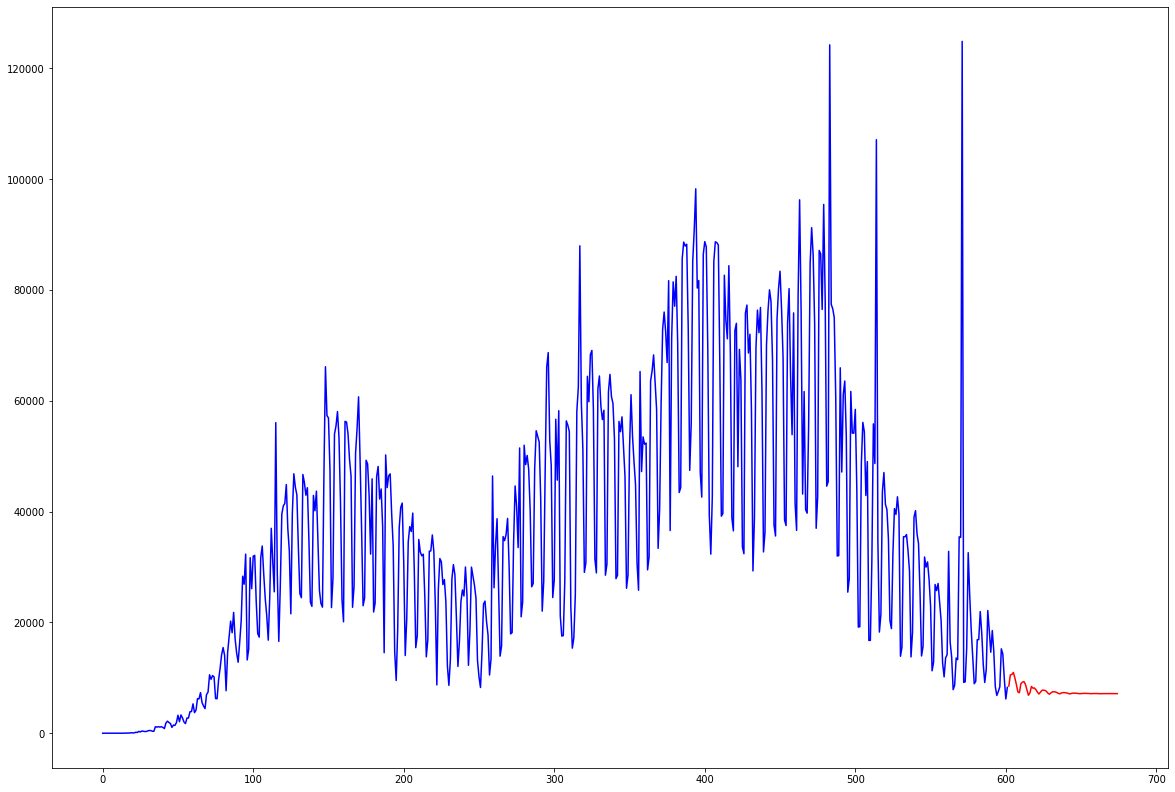

In [18]:
X = np.array(data_BR.newCases)
X = X.astype('float32').reshape(-1,1)

# Prepara o vetor para plotagem dos valores originais
originalX = np.empty([len(X)+len(previsoes_final_ano), ]).reshape(-1,1)
originalX[:, :] = np.nan
originalX[0:len(X), :] = X

# Prepara o vetor para plotagem do conjunto das predições
PredictPlot = np.empty_like(originalX)
PredictPlot[:, :] = np.nan
PredictPlot[len(X):len(X)+len(testPredict), :] = previsoes_final_ano

# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(originalX, color = 'b')
plt.plot(PredictPlot, color='r')
plt.show()

In [19]:
previsoes_final_ano

array([[ 8519.464 ],
       [10514.865 ],
       [10610.268 ],
       [10963.2295],
       [ 9982.696 ],
       [ 8796.895 ],
       [ 7451.067 ],
       [ 7304.174 ],
       [ 8947.021 ],
       [ 9201.789 ],
       [ 9325.729 ],
       [ 8831.718 ],
       [ 7860.065 ],
       [ 6851.2   ],
       [ 7269.3804],
       [ 8435.23  ],
       [ 8126.149 ],
       [ 8163.934 ],
       [ 7861.8726],
       [ 7395.949 ],
       [ 7077.533 ],
       [ 7397.3228],
       [ 7737.7695],
       [ 7773.1265],
       [ 7717.551 ],
       [ 7552.301 ],
       [ 7209.001 ],
       [ 7034.788 ],
       [ 7289.1523],
       [ 7476.6216],
       [ 7479.702 ],
       [ 7447.515 ],
       [ 7331.2656],
       [ 7165.416 ],
       [ 7113.4478],
       [ 7269.849 ],
       [ 7329.084 ],
       [ 7323.9043],
       [ 7295.0776],
       [ 7228.59  ],
       [ 7122.6323],
       [ 7109.888 ],
       [ 7211.4746],
       [ 7231.6025],
       [ 7228.5503],
       [ 7209.0254],
       [ 7160.7705],
       [ 7129

In [24]:
previsoes_proximo_ano = predict_for_next_year(data_BR, look_back)

Prevendo casos para o próximo ano!!
prevendo taxa de casos para o dia 1 do próximo ano
prevendo taxa de casos para o dia 2 do próximo ano
prevendo taxa de casos para o dia 3 do próximo ano
prevendo taxa de casos para o dia 4 do próximo ano
prevendo taxa de casos para o dia 5 do próximo ano
prevendo taxa de casos para o dia 6 do próximo ano
prevendo taxa de casos para o dia 7 do próximo ano
prevendo taxa de casos para o dia 8 do próximo ano
prevendo taxa de casos para o dia 9 do próximo ano
prevendo taxa de casos para o dia 10 do próximo ano
prevendo taxa de casos para o dia 11 do próximo ano
prevendo taxa de casos para o dia 12 do próximo ano
prevendo taxa de casos para o dia 13 do próximo ano
prevendo taxa de casos para o dia 14 do próximo ano
prevendo taxa de casos para o dia 15 do próximo ano
prevendo taxa de casos para o dia 16 do próximo ano
prevendo taxa de casos para o dia 17 do próximo ano
prevendo taxa de casos para o dia 18 do próximo ano
prevendo taxa de casos para o dia 19 

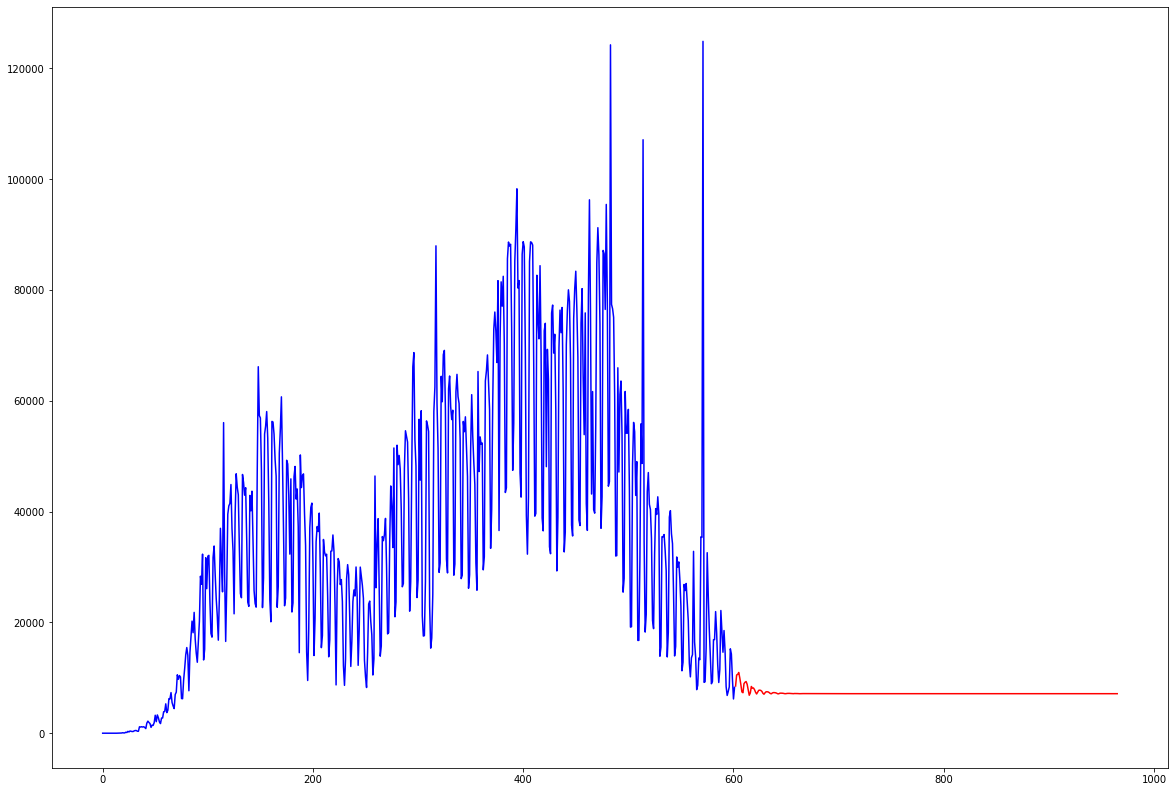

In [26]:
X = np.array(data_BR.newCases)
X = X.astype('float32').reshape(-1,1)

# Prepara o vetor para plotagem dos valores originais
originalX = np.empty([len(X)+len(previsoes_proximo_ano), ]).reshape(-1,1)
originalX[:, :] = np.nan
originalX[0:len(X), :] = X

# Prepara o vetor para plotagem do conjunto das predições
PredictPlot = np.empty_like(originalX)
PredictPlot[:, :] = np.nan
PredictPlot[len(X):len(X)+len(previsoes_proximo_ano), :] = previsoes_proximo_ano

# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(originalX, color = 'b')
plt.plot(PredictPlot, color='r')
plt.show()

In [27]:
previsoes_proximo_ano

array([[ 8519.464 ],
       [10514.865 ],
       [10610.268 ],
       [10963.2295],
       [ 9982.696 ],
       [ 8796.895 ],
       [ 7451.067 ],
       [ 7304.174 ],
       [ 8947.021 ],
       [ 9201.789 ],
       [ 9325.729 ],
       [ 8831.718 ],
       [ 7860.065 ],
       [ 6851.2   ],
       [ 7269.3804],
       [ 8435.23  ],
       [ 8126.149 ],
       [ 8163.934 ],
       [ 7861.8726],
       [ 7395.949 ],
       [ 7077.533 ],
       [ 7397.3228],
       [ 7737.7695],
       [ 7773.1265],
       [ 7717.551 ],
       [ 7552.301 ],
       [ 7209.001 ],
       [ 7034.788 ],
       [ 7289.1523],
       [ 7476.6216],
       [ 7479.702 ],
       [ 7447.515 ],
       [ 7331.2656],
       [ 7165.416 ],
       [ 7113.4478],
       [ 7269.849 ],
       [ 7329.084 ],
       [ 7323.9043],
       [ 7295.0776],
       [ 7228.59  ],
       [ 7122.6323],
       [ 7109.888 ],
       [ 7211.4746],
       [ 7231.6025],
       [ 7228.5503],
       [ 7209.0254],
       [ 7160.7705],
       [ 7129